In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_utils.loader import DataLoader

In [ ]:
DB_PATH = "data/processed/lakehouse.sqlite"
ff5_features = ['mvel1', 'bm', 'mom12m', 'mom1m', 'retvol'] # Not fama french 5, i think

loader = DataLoader(DB_PATH)
df = loader.load_panel_data(
    feature_cols = ff5_features, 
    target_col = 'target_ret_excess'
)

[2026-02-05 15:15:59] [INFO] [DB_Loader] STREAMING DATA, NUMBER OF COLUMNS: 8...
[2026-02-05 15:16:13] [INFO] [DB_Loader] DATA LOADED SUCCESSFULLY. USING: 0.21 GB
[2026-02-05 15:16:13] [INFO] [DB_Loader] CONNECTION CLOSED


# Stat Properties

In [3]:
df['target_ret_excess'].describe()

count    3.273562e+06
mean     5.847409e-03
std      1.807153e-01
min     -1.000000e+00
25%     -7.165175e-02
50%     -4.300000e-03
75%      6.617600e-02
max      2.399660e+01
Name: target_ret_excess, dtype: float64

## Empirical PDF

In [4]:
# Get the 0.05th and 99.95th percentiles to exclude extreme tails
lower_bound = df['target_ret_excess'].quantile(0.0005)
upper_bound = df['target_ret_excess'].quantile(0.9995)

filtered_df = df['target_ret_excess'][
    (df['target_ret_excess'] >= lower_bound) & (df['target_ret_excess'] <= upper_bound)
]


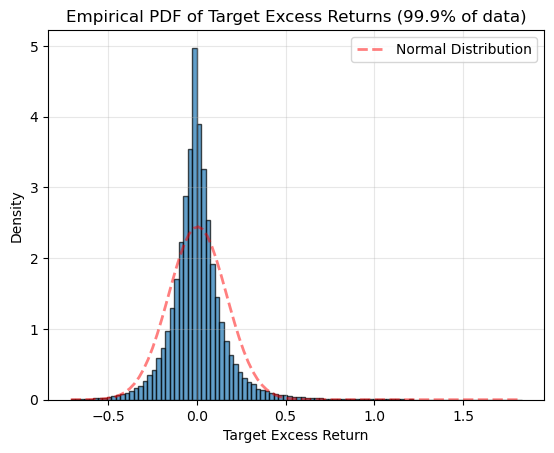

In [5]:
mu = filtered_df.mean()
sigma = filtered_df.std()
x = np.linspace(filtered_df.min(), filtered_df.max(), 100)
normal_pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

plt.hist(filtered_df, bins=100, density=True, alpha=0.7, edgecolor='black')
plt.plot(x, normal_pdf, 'r--', linewidth=2, alpha=0.5, label='Normal Distribution')
plt.xlabel('Target Excess Return')
plt.ylabel('Density')
plt.title('Empirical PDF of Target Excess Returns (99.9% of data)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Empirical CDF

c:\Users\rcorr\anaconda3\envs\asset_pricing\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


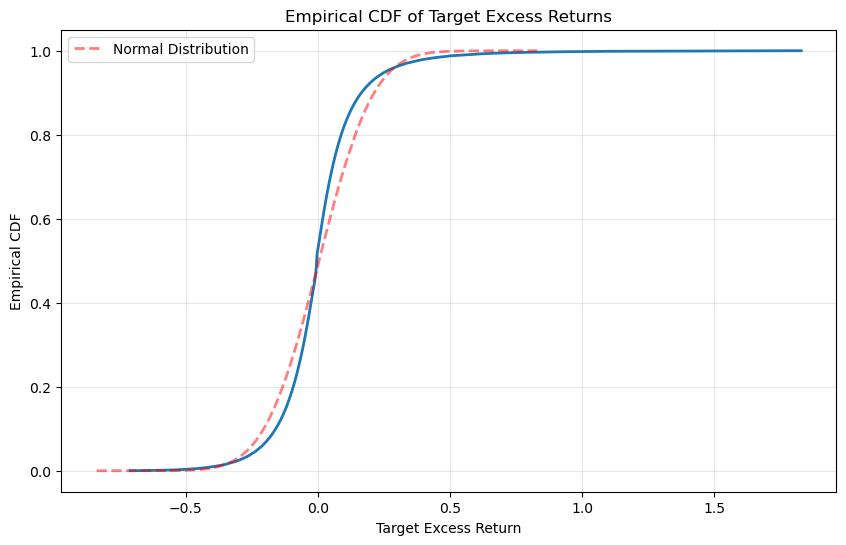

In [6]:
sorted_data = np.sort(filtered_df.dropna())
norm_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(10, 6))
plt.plot(sorted_data, ecdf, linewidth=2)
plt.plot(np.sort(np.random.normal(mu, sigma, len(sorted_data))), norm_cdf, 'r--', linewidth=2, alpha=0.5, label='Normal Distribution')
plt.xlabel('Target Excess Return')
plt.ylabel('Empirical CDF')
plt.title('Empirical CDF of Target Excess Returns')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## QQ Plot

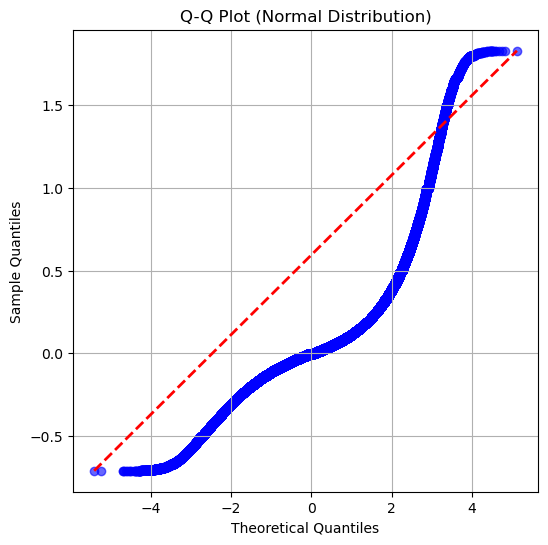

In [7]:
n_samples = len(filtered_df)
std_norm = np.random.standard_normal(n_samples)
sorted_std_norm = np.sort(std_norm)

plt.figure(figsize=(6, 6))
plt.scatter(sorted_std_norm, sorted_data, color='blue', alpha=0.6)
plt.plot(
    [sorted_std_norm.min(), sorted_std_norm.max()],
    [sorted_data.min(), sorted_data.max()],
    'r--', linewidth=2
)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot (Normal Distribution)')
plt.grid(True)
plt.show()

## Stochastic Process Analysis

In [ ]:
df.columns